# CVRP 

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum, LinExpr
import itertools

def read_elem(filename):
    with open(filename) as f:
        return [str(elem) for elem in f.read().split()]

def read_input_cvrp(filename):
    file_it = iter(read_elem(filename))

    nb_nodes = 0
    while(1):
        token = next(file_it)
        if token == "DIMENSION":
            next(file_it) # Removes the ":"
            nb_nodes = int(next(file_it))
            nb_customers = nb_nodes - 1
        elif token == "CAPACITY":
            next(file_it) # Removes the ":"
            truck_capacity = int(next(file_it))
        elif token == "EDGE_WEIGHT_TYPE":
            next(file_it) # Removes the ":"
            token = next(file_it)
            if token != "EUC_2D":
                print("Edge Weight Type " + token + " is not supported (only EUD_2D)")
                sys.exit(1)
        elif token == "NODE_COORD_SECTION":
            break

    customers_x = [None]*nb_customers
    customers_y = [None]*nb_customers
    depot_x = 0
    depot_y = 0
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n+1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            depot_x = int(next(file_it))
            depot_y = int(next(file_it))
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            customers_x[node_id-2] = int(next(file_it))
            customers_y[node_id-2] = int(next(file_it))

    token = next(file_it)
    if token != "DEMAND_SECTION":
        print("Expected token DEMAND_SECTION")
        sys.exit(1)

    demands = [None]*nb_customers
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n+1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            if int(next(file_it)) != 0:
                print("Demand for depot should be 0")
                sys.exit(1)
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            demands[node_id-2] = int(next(file_it))

    token = next(file_it)
    if token != "DEPOT_SECTION":
        print("Expected token DEPOT_SECTION")
        sys.exit(1)

    warehouse_id = int(next(file_it))
    if warehouse_id != 1:
        print("Warehouse id is supposed to be 1")
        sys.exit(1)

    end_of_depot_section = int(next(file_it))
    if end_of_depot_section != -1:
        print("Expecting only one warehouse, more than one found")
        sys.exit(1)

    return nb_customers, truck_capacity, np.array(demands), np.array(customers_x), np.array(customers_y), depot_x, depot_y


def get_nb_trucks(filename):
    begin = filename.rfind("-k")
    if begin != -1:
        begin += 2
        end = filename.find(".", begin)
        return int(filename[begin:end])
    print("Error: nb_trucks could not be read from the file name. Enter it from the command line")
    sys.exit(1)



In [85]:
# customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp('X-n303-k21.vrp')
customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp('X-n502-k39.vrp')
# customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp('X-n101-k25.vrp')

vertexes = list(range(customers_num+1))
edges = [(i, j) for i in vertexes for j in vertexes if i != j]

In [92]:
def solve_it(customers, vehicle_capacity, customers_x, customers_y, demands, customers_num, depot_x, depot_y):
    
    customers_ils = [Customer(i+1, customers_x[i], customers_y[i], demands[i]) for i in range(customers_num)]
    depot_ils = Customer(0, depot_x, depot_y, 0)
    problem = Problem('a', [depot_ils]+customers_ils, vehicle_capacity)
    
#     customers_ils = [Customer(i, customers[i].x, customers[i].x, customers[i].demand) for i in range(len(customers))]
#     problem = Problem('a', customers_ils, vehicle_capacity)
#     init_solution = DummyHeuristic(problem).get_solution()
    init_solution, steps = IteratedLocalSearch(problem, 100, 1).execute(print_steps=True)
    
    
    clients = customers[1:]

    cust_dist = {}
    
    def length(cus1, cus2):
        return np.hypot(cus1.x-cus2.x, cus1.y-cus2.y)
    
    for i in customers:
        for j in customers:
            if i.index != j.index:
                cust_dist[i.index, j.index] = length(i,j)

    m = Model("CVRP")

    path = {}
    for i in customers:
        for j in customers:
            if i.index != j.index:
                path[i.index,j.index] = m.addVar(vtype=GRB.BINARY, name="Path   "+ str(i.index) +"  "+ str(j.index))
                path[i.index,j.index].start = 0
    
    for route in init_solution:
        for source, target in zip(route.allRouteCustomers, route.allRouteCustomers[1:]):
            path[source.number, target.number].start = 1
            

    vCap = {}
    for i in customers:
        if i.index !=0:
            vCap[i.index] = m.addVar(lb=i.demand, ub=vehicle_capacity, name="vCap   "+str(i.index))

    m.update()

    obj = quicksum(path[i.index,j.index]*cust_dist[i.index, j.index] for i in customers for j in customers if i.index!=j.index)

    m.setObjective(obj)

    for j in clients:
        m.addConstr(quicksum(path[i.index,j.index] for i in customers if i.index != j.index) == 1)
    for i in clients:
        m.addConstr(quicksum(path[i.index, j.index] for j in customers if i.index != j.index) == 1)

    for i in clients:
        m.addConstr(vCap[i.index] <= vehicle_capacity + (i.demand - vehicle_capacity)*path[0,i.index])

    for i in clients:
        for j in clients:
            if i==j:
                continue
            m.addConstr(vCap[i.index] - vCap[j.index] + vehicle_capacity*path[i.index,j.index] <=vehicle_capacity - j.demand)
    
    m.Params.TimeLimit = 1200  # seconds
    m.Params.MIPFocus= 1 #так как надо в первую очередь найти точное решение, а уже потом доказывать его оптимальность
    m.Params.Presolve = 2 #так как нет взаимосвязанных переменных и т.п.
    m.Params.NoRelHeurTime = 200 #эвристика дает возможность еще получить еще лучше стартовое решение, прежде чем начинать решать 
    m.Params.Method = 1 #подобрано опытным путем (хотя большой разницы не заметил)
    m.Params.ImproveStartTime = 800  #поскольку мы алгоритм ограничен по времени, нам важнее получить лучшее возможное решение, не доказывая оптимальность
    
    m.update()
    m.optimize()

    active_arcs = [a for a in edges if path[a].x == 1]

    return m.ObjVal, active_arcs

In [93]:
from collections import namedtuple
Customer_gurobi = namedtuple("Customer", ['index', 'demand', 'x', 'y'])
customers = [Customer_gurobi(0, 0, depot_x, depot_y)] #depot
customers += [Customer_gurobi(i+1, demands[i], customers_x[i], customers_y[i]) for i in range(customers_num)]

obj, active_arcs = solve_it(customers, truck_capacity, customers_x, customers_y, demands, customers_num, depot_x, depot_y)
obj

DummyHeuristic solution has length 280145.33803392254
Local search solution:
Total distance 118560.99822423533
ILS step
Total distance 72756.03259557503
ILS step
Total distance 71772.53275248136
ILS step
Total distance 71357.81561949162
ILS step
Total distance 71157.67278991814
Changed value of parameter TimeLimit to 1200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPFocus to 1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NoRelHeurTime to 200.0
   Prev: 0.0  Min: 0.0  Max: inf  Default: 0.0
Changed value of parameter Method to 1
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter ImproveStartTime to 800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 252003 rows, 252003 columns 

71110.04526798477

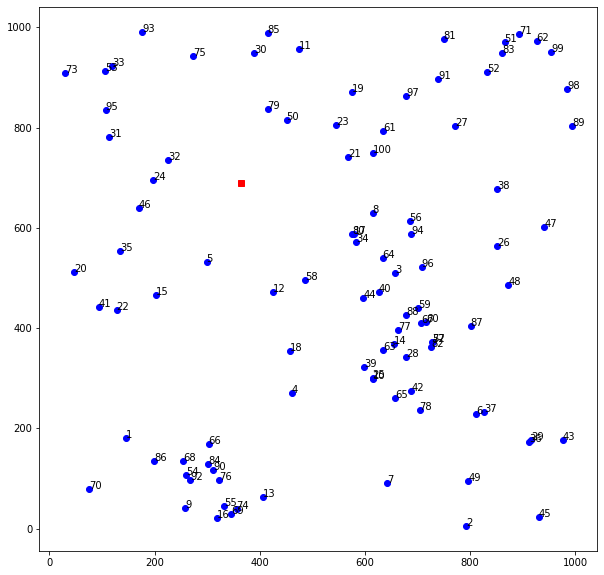

In [160]:
plt.figure(figsize=(10, 10))
plt.scatter(customers_x, customers_y, c='b')
for i in range(customers_num):
    plt.text(customers_x[i], customers_y[i],str(i+1))
plt.plot(depot_x, depot_y, c='r', marker='s')


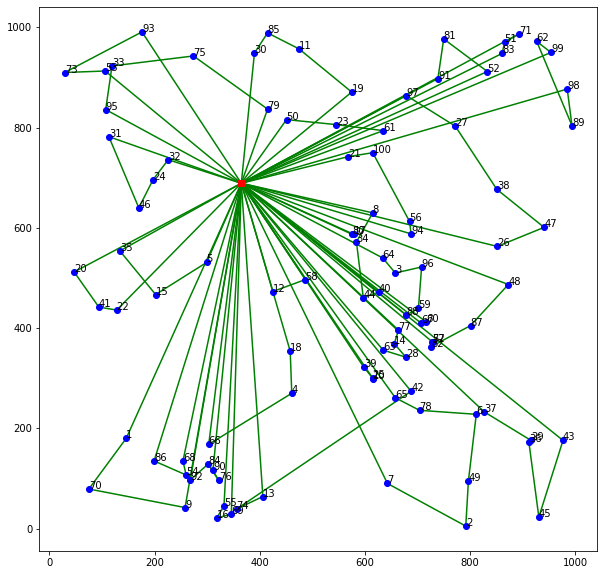

In [121]:
plt.figure(figsize=(10, 10))
plt.plot(depot_x, depot_y, c='r', marker='s')
plt.scatter(customers_x, customers_y, c='b')
for i, j in active_arcs:
    if i == 0:
        plt.plot([depot_x, customers_x[j-1]], [depot_y, customers_y[j-1]], c='g', zorder=0)
    elif j == 0:
        plt.plot([depot_x, customers_x[i-1]], [depot_y, customers_y[i-1]], c='g', zorder=0)
    else:
        plt.plot([customers_x[i-1], customers_x[j-1]], [customers_y[i-1], customers_y[j-1]], c='g', zorder=0)
        
for i in range(customers_num):
    plt.text(customers_x[i], customers_y[i],str(i+1))


In [171]:
from collections import namedtuple
filenames = ['X-n101-k25.vrp', 'X-n200-k36.vrp', 'X-n303-k21.vrp', 'X-n401-k29.vrp', 'X-n502-k39.vrp']

objs = []
routes = []
route_demands = []
for f in filenames:
    customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp(f)
    vertexes = list(range(customers_num+1))
    edges = [(i, j) for i in vertexes for j in vertexes if i != j]
    Customer_gurobi = namedtuple("Customer", ['index', 'demand', 'x', 'y'])
    customers = [Customer_gurobi(0, 0, depot_x, depot_y)] #depot
    customers += [Customer_gurobi(i+1, demands[i], customers_x[i], customers_y[i]) for i in range(customers_num)]
    
    obj, active_arcs = solve_it(customers, truck_capacity)
    objs.append(obj)
    routes.append(active_arcs)
    route_demands.append(demands)
for i in objs:
    print("{:.2f}".format(i))

DummyHeuristic solution has length 51268.07006314945
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPFocus to 1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter NoRelHeurTime to 20.0
   Prev: 0.0  Min: 0.0  Max: inf  Default: 0.0
Changed value of parameter Method to 1
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter ImproveStartTime to 10.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 10200 rows, 10200 columns and 49900 nonzeros
Model fingerprint: 0x7aba3c0b
Variable types: 100 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 2e+

     0     0 7278.91893    0  257 28712.6275 7278.91893  74.6%     -   28s
     0     0 7283.46689    0  251 28712.6275 7283.46689  74.6%     -   28s
     0     0 7283.57119    0  249 28712.6275 7283.57119  74.6%     -   28s
     0     0 7283.78743    0  266 28712.6275 7283.78743  74.6%     -   28s
     0     0 7283.78743    0  266 28712.6275 7283.78743  74.6%     -   28s
     0     0 7315.26443    0  260 28712.6275 7315.26443  74.5%     -   28s

Resetting heuristic parameters to focus on improving solution
(using Heuristics=0.5 and RINS=10)...

     2     4 7316.81400    1  258 28712.6275 7315.36802  74.5%  67.0   32s
H   12    16                    28691.537368 7327.93937  74.5%  64.7   34s
H   14    16                    28686.267450 7341.10475  74.4%  65.8   34s
    16    26 7341.69001    4  255 28686.2675 7341.10475  74.4%  69.0   37s
H   17    26                    28680.459706 7341.10475  74.4%  64.9   37s
H   23    26                    28663.586449 7341.10475  74.4%  80.6   37

Found heuristic solution: objective 65945.266258
Found heuristic solution: objective 65942.938995
Found heuristic solution: objective 65924.286814
Found heuristic solution: objective 65784.365920
Found heuristic solution: objective 65723.395171
Found heuristic solution: objective 65665.210306

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.567000e+03   0.000000e+00     20s
     970    5.9413958e+03   0.000000e+00   0.000000e+00     20s

Root relaxation: objective 5.941396e+03, 970 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5941.39578    0  393 65665.2103 5941.39578  91.0%     -   20s
H    0     0                    65624.231157 5941.39578  90.9%     -   20s
     0     0 5972.22050    0  398 65624.2312 5972.22050  90.9%     -   22s
H    0     0                    65577.421056

Found heuristic solution: objective 35793.221488
Found heuristic solution: objective 35612.637594
Found heuristic solution: objective 35565.824339
Found heuristic solution: objective 35308.495387
Found heuristic solution: objective 35180.120819
Found heuristic solution: objective 34806.640622
Found heuristic solution: objective 34662.923220
Found heuristic solution: objective 34512.083593
Found heuristic solution: objective 34398.862717
Found heuristic solution: objective 34358.443551
Found heuristic solution: objective 34344.563350
Found heuristic solution: objective 34263.194463
Found heuristic solution: objective 34226.334286

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.966000e+03   0.000000e+00     21s
    1356    8.8715685e+03   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 8.871568e+03, 1356 iterations, 0.28 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex


     0     0 9088.74385    0  781 104082.430 9088.74385  91.3%     -   22s
H    0     0                    103625.54951 9088.74385  91.2%     -   22s
     0     0 9143.89727    0  820 103625.550 9143.89727  91.2%     -   36s
H    0     0                    103399.48459 9143.89727  91.2%     -   49s
     0     0 9233.52478    0  850 103399.485 9233.52478  91.1%     -   49s
     0     0 9233.52478    0  847 103399.485 9233.52478  91.1%     -   49s
     0     0 9264.73607    0  843 103399.485 9264.73607  91.0%     -   59s

Cutting planes:
  Learned: 3
  Gomory: 4
  Implied bound: 33
  MIR: 76
  Relax-and-lift: 19

Explored 1 nodes (3389 simplex iterations) in 60.03 seconds
Thread count was 20 (of 20 available processors)

Solution count 10: 103399 103626 104082 ... 105886

Time limit reached
Best objective 1.033994845868e+05, best bound 9.264736072405e+03, gap 91.0399%
DummyHeuristic solution has length 205765.24489816057
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.

    BKS:             27591     58578     21736     66154      69226
    
    Gurobi default:
    Gurobi 30 sec:   29953.57, 65609.91, 29273.42, 82128.89, 740248.51
    Gurobi 60 sec:   29885.34, 63769.07, 29172.33, 78554.92, 79226.92
    Gurobi 300 sec:  29885.34, 63134.22, 27564.07, 74153.06, 76639.48
    
    Gurobi tuned:
    Gurobi 30 sec:   28712.63  65594.92  43756.54  132026.68  242935.65
    Gurobi 60 sec:   28620.29  64927.14  32227.04  103399.48  100150.67
    Gurobi 300 sec:  28426.00  62525.67  26810.24  77717.89  76821.92
    
    
Средняя ошибка дефолтного гуроби: 13,1% 
Средняя ошибка тюненого гуроби:   12,3%


In [172]:
def check_gurobi_correctness(arcs, demands, truck_capacity):
    used_arcs = np.zeros(len(arcs), dtype=bool)
    for start_arc_id in range(len(arcs)):
        if arcs[start_arc_id][0] !=0:
            continue
            
        if used_arcs[start_arc_id]:
            continue
        current_node = 0
        demand = 0
        for arc_id in range(len(arcs)):
            if current_node == 0:
                demand = 0
            if arcs[arc_id][0] == current_node and not used_arcs[arc_id]:
                used_arcs[arc_id] = True
                current_node=arcs[arc_id][1]
                demand+=demands[arcs[arc_id][1]]
            elif arcs[arc_id][1] == current_node and not used_arcs[arc_id]:
                used_arcs[arc_id] = True
                current_node=arcs[arc_id][0]
                demand+=demands[arcs[arc_id][0]]
            
            if demand>truck_capacity:
                raise ValueError("demand of route is bigger than truck capacity!")
    print('OK')

for f, route in zip(filenames, routes):
    customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp(f)
    check_gurobi_correctness(route, [0]+list(demands), truck_capacity)
    

OK
OK
OK
OK
OK


# ILS

In [34]:
import math

class Customer:
    def __init__(self, number, x, y, demand):
        self.number = number
        self.x = x
        self.y = y
        self.demand = demand
        self.is_serviced = False

    def __repr__(self):
        return f"C_{self.number}"

    def distance(self, target):
        return math.sqrt(math.pow(self.x - target.x, 2) + math.pow(target.y - self.y, 2))


class Problem:
    def __init__(self, name, customers: list, vehicle_capacity):
        self.name = name
        self.customers = customers
        self.vehicle_capacity = vehicle_capacity
        self.depot: Customer = list(filter(lambda x: x.number == 0, customers))[0]
        self.depot.is_serviced = True
        self.customers_num = len(self.customers)
        self.dists = np.zeros((self.customers_num+1, self.customers_num+1))
        
        for i in self.customers:
            for j in self.customers:
                if i!=j:
                    self.dists[i.number, j.number] = np.hypot(i.x-j.x, i.y-j.y)

    def obj_func(self, routes):
        return sum(map(lambda x: x.total_distance, routes))
                    
    def two_customers_distance(self, i, j):
        return self.dists[i.number, j.number]


class Route:
    def __init__(self, problem: Problem, customers: list):
        self.problem: Problem = problem
        self._customers: list = [self.problem.depot, *customers, self.problem.depot]

    def __repr__(self):
        return " ".join(str(customer.number) for customer in self._customers)
    
    @property
    def allRouteCustomers(self):
        return self._customers

    @property
    def customers(self):
        return self._customers[1:-1]

    @property
    def total_distance(self):
        dist = 0
        for source, target in zip(self._customers, self._customers[1:]):
            dist+= self.problem.two_customers_distance(source, target)
        return dist

    @property
    def edges(self):
        return list(zip(self._customers, self._customers[1:]))

    @property
    def is_feasible(self):
        time = 0
        capacity = self.problem.vehicle_capacity
        is_feasible = True
        for source, target in zip(self._customers, self._customers[1:]):
            capacity -= target.demand
        if capacity < 0:
            is_feasible = False
        return is_feasible

In [35]:
import random

def two_opt(a, i, j):
    if i == 0:
        return a[j:i:-1] + [a[i]] + a[j + 1:]
    return a[:i] + a[j:i - 1:-1] + a[j + 1:]

def cross(a, b, i, j):
    return a[:i] + b[j:], b[:j] + a[i:]

def insertion(a, b, i, j):
    if len(a) == 0:
        return a, b
    while i >= len(a):
        i -= len(a)
    return a[:i] + a[i + 1:], b[:j] + [a[i]] + b[j:]

def swap(a, b, i, j):
    if i >= len(a) or j >= len(b):
        return a, b
    a, b = a.copy(), b.copy()
    a[i], b[j] = b[j], a[i]
    return a, b

class DummyHeuristic:
    def __init__(self, problem: Problem):
        self.problem: Problem = problem

    def get_solution(self):
        """Solution sampled from customer list, sorted by demand"""

        def get_available_customers():
            return list(filter(lambda x: not x.is_serviced, self.problem.customers))

        solution = []
        while len(get_available_customers()) > 0:
            customers = get_available_customers()
            route = []
            for customer in customers:
                if Route(self.problem, route + [customer]).is_feasible:
                    customer.is_serviced = True
                    route.append(customer)
            solution.append(Route(self.problem, route))
        print(f'DummyHeuristic solution has length {sum(i.total_distance for i in solution)}')
        return solution


class IteratedLocalSearch():
    def __init__(self, problem: Problem, pertrubation_number, patience):
        self.patience = patience
        self.problem: Problem = problem
        self.pertrubation_number = pertrubation_number
        self.obj_func = self.problem.obj_func
        self.initial_solution = DummyHeuristic(problem).get_solution()
    
    def two_opt_optimize(self, solution: list) -> list:
        new_solution = list(solution)
        for i in range(len(new_solution)):
            is_stucked = False
            while not is_stucked:
                route = new_solution[i]
                is_stucked = True
                for k, j in itertools.combinations(range(len(route.customers)), 2):
                    new_route = Route(self.problem, two_opt(route.customers, k, j))
                    if new_route.is_feasible:
                        if new_route.total_distance < route.total_distance:
                            new_solution[i] = new_route
                            is_stucked = False
        return new_solution
        
    
    def local_search(self, routes: list) -> list:        
        best = [Route(self.problem, route.customers) for route in routes]
        is_stucked = False
        while not is_stucked :
            is_stucked = True
#             Для всех возможных пар маршрутов
            for i, j in itertools.combinations(range(len(best)), 2):
                # Для всех возможных индексов в двух маршрутах
                for k, l in itertools.product(range(len(best[i].customers) + 2), range(len(best[j].customers) + 2)):
                    for func in [cross, insertion, swap]:
                        c1, c2 = func(best[i].customers, best[j].customers, k, l)
                        r1, r2 = Route(self.problem, c1), Route(self.problem, c2)
                        if r1.is_feasible and r2.is_feasible:
                            if r1.total_distance + r2.total_distance < best[i].total_distance + best[j].total_distance:
                                best[i] = r1
                                best[j] = r2
                                is_stucked = False
            best = list(filter(lambda x: len(x.customers) != 0, best))
        return best
    
    def pertrubate(self, routes: list) ->list:
        routes = routes.copy()
        iter_count = 0
        while iter_count < self.pertrubation_number:
            route_1_id, route_2_id = random.sample(list(range(len(routes))), k=2)
#             custtomer_1_1, custtomer_1_1 = random.sample(routes[route_1_id].customers, k=2)
#             custtomer_2_1, custtomer_2_1 = random.sample(routes[route_2_id].customers, k=2)
            k, l = random.choice(list(range(len(routes[route_1_id].customers) + 2))), random.choice(list(range(len(routes[route_2_id].customers) + 2))) 
            func = random.choice([cross, insertion, swap])
            c1, c2 = func(routes[route_1_id].customers, routes[route_2_id].customers, k, l)
            r1, r2 = Route(self.problem, c1), Route(self.problem, c2)
            if r1.is_feasible and r2.is_feasible:
                routes[route_1_id] = r1
                routes[route_2_id] = r2
                iter_count+=1
        return routes
        

    def execute(self, print_steps=False):
        best = self.two_opt_optimize(self.initial_solution)
        steps = []
        steps.append(self.obj_func(best))
        if print_steps:
            print("Local search solution:")
            print("Total distance", self.obj_func(best))
        

        is_stucked = False
        while not is_stucked:
            is_stucked = True
            new_solution = self.pertrubate(best)
            new_solution = self.local_search(new_solution)
            new_solution = self.two_opt_optimize(new_solution)
            steps.append(self.obj_func(new_solution))
            try_count=0
            while self.obj_func(new_solution) >= self.obj_func(best) and try_count<self.patience:
#                 print(try_count)
                new_solution = self.pertrubate(best)
                new_solution = self.local_search(new_solution)
                new_solution = self.two_opt_optimize(new_solution)
                try_count+=1
            
                
            
            if self.obj_func(new_solution) < self.obj_func(best):
                is_stucked = False
                best = list(filter(lambda x: len(x.customers) != 0, new_solution))
                if print_steps:
                    print("ILS step")
                    print("Total distance", self.obj_func(best))
            
        return best, steps
    

In [86]:
customers = [Customer(i+1, customers_x[i], customers_y[i], demands[i]) for i in range(customers_num)]
depot = Customer(0, depot_x, depot_y, 0)
problem = Problem('a', [depot]+customers, truck_capacity)

In [87]:
ils = IteratedLocalSearch(problem, 100, 0)
bestRoutes, steps = ils.execute(print_steps=True)
plt.figure(figsize=(15, 5))
plt.plot(steps)
print(sum(i.total_distance for i in bestRoutes))

DummyHeuristic solution has length 280145.33803392254
Local search solution:
Total distance 118560.99822423533
ILS step
Total distance 72339.85482774094


KeyboardInterrupt: 

In [73]:
for route in bestRoutes:
    for c, z in zip(route.allRouteCustomers, route.allRouteCustomers[1:]):
        print(c, z)

C_0 C_84
C_84 C_90
C_90 C_9
C_9 C_13
C_13 C_0
C_0 C_66
C_66 C_92
C_92 C_55
C_55 C_76
C_76 C_0
C_0 C_1
C_1 C_70
C_70 C_4
C_4 C_0
C_0 C_19
C_19 C_97
C_97 C_61
C_61 C_0
C_0 C_31
C_31 C_46
C_46 C_35
C_35 C_0
C_0 C_80
C_80 C_17
C_17 C_94
C_94 C_0
C_0 C_5
C_5 C_12
C_12 C_58
C_58 C_0
C_0 C_100
C_100 C_27
C_27 C_38
C_38 C_56
C_56 C_0
C_0 C_93
C_93 C_75
C_75 C_0
C_0 C_63
C_63 C_42
C_42 C_28
C_28 C_14
C_14 C_0
C_0 C_23
C_23 C_21
C_21 C_8
C_8 C_0
C_0 C_52
C_52 C_91
C_91 C_50
C_50 C_0
C_0 C_26
C_26 C_47
C_47 C_48
C_48 C_6
C_6 C_88
C_88 C_0
C_0 C_89
C_89 C_98
C_98 C_99
C_99 C_62
C_62 C_71
C_71 C_0
C_0 C_32
C_32 C_33
C_33 C_53
C_53 C_73
C_73 C_95
C_95 C_24
C_24 C_0
C_0 C_25
C_25 C_65
C_65 C_78
C_78 C_49
C_49 C_2
C_2 C_7
C_7 C_0
C_0 C_74
C_74 C_69
C_69 C_16
C_16 C_0
C_0 C_18
C_18 C_10
C_10 C_39
C_39 C_0
C_0 C_15
C_15 C_22
C_22 C_41
C_41 C_20
C_20 C_0
C_0 C_67
C_67 C_77
C_77 C_44
C_44 C_0
C_0 C_68
C_68 C_54
C_54 C_86
C_86 C_0
C_0 C_30
C_30 C_85
C_85 C_11
C_11 C_79
C_79 C_0
C_0 C_40
C_40 C_60
C_60 C_59

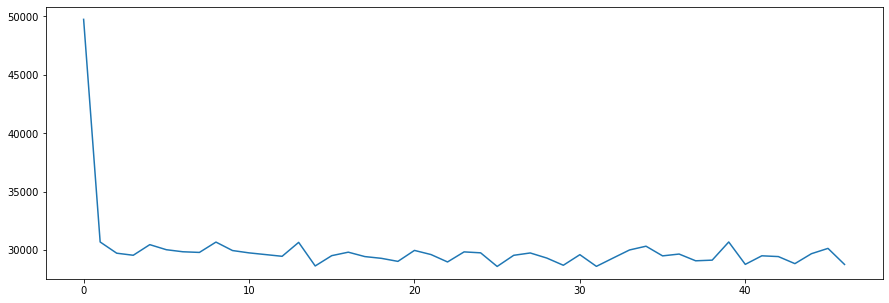

In [128]:
plt.figure(figsize=(15, 5))
plt.plot(steps)

In [129]:
sum(i.total_distance for i in bestRoutes)

28610.746025519275

In [130]:
def check_correctness(routes):
    for route in routes:
        route_demand = 0
        for customer in route.allRouteCustomers[1:]:
            route_demand+=customer.demand
#         print(route_demand)
        if route_demand>truck_capacity:
            raise ValueError('sum of demands of route is bigger than truck capacity!')
#     print('OK')
        
check_correctness(bestRoutes)

In [131]:
def plotRoutes(routes):
    for route in routes:
        coordsX = []
        coordsY = []
        for customer in route.allRouteCustomers:
            coordsX.append(customer.x)
            coordsY.append(customer.y)
            plt.text(customer.x, customer.y, customer.number)
        plt.plot(coordsX, coordsY)
    plt.show()


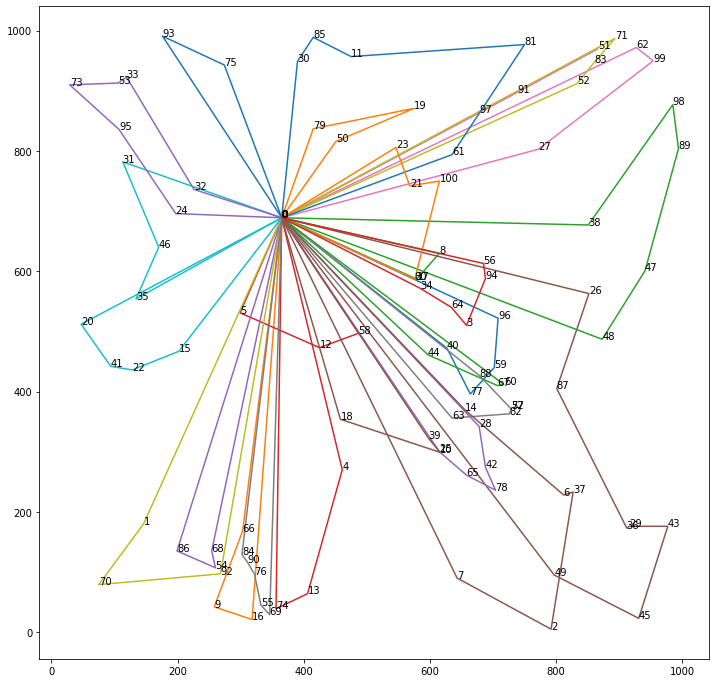

In [132]:
plt.figure(figsize=(12, 12))
plotRoutes(bestRoutes)

In [114]:
from pqdm.processes import pqdm

def get_best_route(filename):
    customers_num, truck_capacity, demands, customers_x, customers_y, depot_x, depot_y = read_input_cvrp(filename)
    vertexes = list(range(customers_num+1))
    edges = [(i, j) for i in vertexes for j in vertexes if i != j]
    
    customers = [Customer(i+1, customers_x[i], customers_y[i], demands[i]) for i in range(customers_num)]
    depot = Customer(0, depot_x, depot_y, 0)
    problem = Problem('a', [depot]+customers, truck_capacity)
    
    ils = IteratedLocalSearch(problem, 10, 5)
    bestRoutes = ils.execute() 
    
    return bestRoutes
    
# filenames = ['X-n101-k25.vrp', 'X-n200-k36.vrp', 'X-n303-k21.vrp', 'X-n401-k29.vrp', 'X-n502-k39.vrp']
filenames = ['X-n502-k39.vrp'] * 5

solutions = pqdm(filenames, get_best_route, n_jobs=5)

In [115]:
dists = []
for s in solutions:
#     check_correctness(s[0])
#     print(sum(i.total_distance for i in s[0]))
    dists.append(sum(i.total_distance for i in s[0]))
np.mean(dists)
# best known solutions:


70521.69233895908

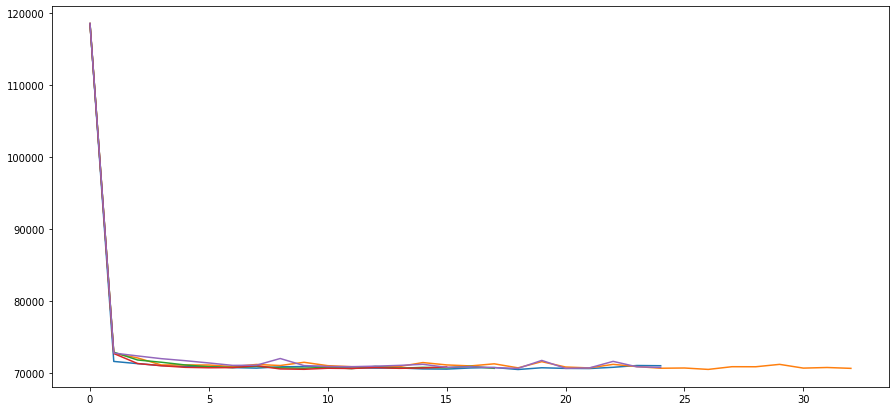

In [116]:
plt.figure(figsize=(15, 7))
for s in solutions:
    plt.plot(s[1])

    Решения эвристики без пертрубации :            

    30697.18348636645               
    60970.11584289823               
    24549.495398000043              
    73567.30498388769               
    72097.02423012242
    
    Решения эвристики с пертрубацией (среднее за 10 запусков с параметрами (10, 5) )
    28768.12187360801
    60566.90748883247
    23211.891727153958
    70374.0511820323
    70521.69233895908
    
    Best known solutions:
    27591
    58578
    21736
    66154
    69226
